In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-05 21:18:45.982870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import mydata as md

data = md.Data('cache')


In [47]:
def custom_standardization(input_data):
  s = tf.strings.lower(input_data)
  s =  tf.strings.regex_replace(s, r'http\S+', ' ')
  s =  tf.strings.regex_replace(s, r'@\S+', ' ')
  s =  tf.strings.regex_replace(s, '[%s]' % re.escape(string.punctuation),' ')
  s =  tf.strings.regex_replace(s, r'\s+', ' ')
    
  return s

In [85]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('twitter')

In [86]:
raw_train_ds = raw_train_ds.map(lambda x,y: (x, keras.utils.to_categorical(y, num_classes=2)))
raw_valid_ds = raw_valid_ds.map(lambda x,y: (x, keras.utils.to_categorical(y, num_classes=2)))
raw_test_ds = raw_test_ds.map(lambda x,y: (x, keras.utils.to_categorical(y, num_classes=2)))


In [89]:
max_features = 20000
sequence_length = 100

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    ngrams=2,
    output_sequence_length=sequence_length
)

In [90]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

In [92]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [100]:
embedding_dim=256

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    tf.keras.layers.Embedding(
        input_dim=(max_features),
        output_dim=embedding_dim,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, None, 256)      │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,128,290 (19.56 MB)

 Trainable params: 5,128,290 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
train_ds_batch=train_ds.batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [101]:
checkpoint_filepath = "models/checkpoint_twitter_model_base.weights.h5"

epochs = 10
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        )        
    ]
)

Epoch 1/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 172s 60ms/step - F1Score: 0.6815 - accuracy: 0.6853 - loss: 0.5756 - val_F1Score: 0.7728 - val_accuracy: 0.7733 - val_loss: 0.4744
Epoch 2/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 185s 65ms/step - F1Score: 0.7690 - accuracy: 0.7691 - loss: 0.4760 - val_F1Score: 0.7882 - val_accuracy: 0.7882 - val_loss: 0.4526
Epoch 3/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 186s 66ms/step - F1Score: 0.7828 - accuracy: 0.7828 - loss: 0.4591 - val_F1Score: 0.7918 - val_accuracy: 0.7919 - val_loss: 0.4439
Epoch 4/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 196s 69ms/step - F1Score: 0.7895 - accuracy: 0.7896 - loss: 0.4478 - val_F1Score: 0.7959 - val_accuracy: 0.7961 - val_loss: 0.4379
Epoch 5/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 184s 65ms/step - F1Score: 0.7935 - accuracy: 0.7936 - loss: 0.4407 - val_F1Score: 0.8013 - val_accuracy: 0.8013 - val_loss: 0.4306
Epoch 6/10
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 189s 67ms/step - F1Score: 0.7974 - accuracy: 0.7975 - loss: 0.4351 - val_F1Score: 0.8039 - va

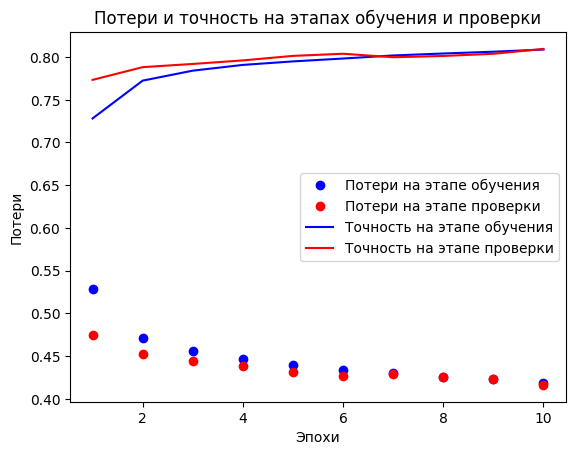

In [102]:
data.plot(history)

In [103]:
model.load_weights(checkpoint_filepath)

In [104]:
model.evaluate(test_ds_batch)

355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - F1Score: 0.8108 - accuracy: 0.8108 - loss: 0.4140


[0.414742648601532,
 0.8101745843887329,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8095701, 0.8107751], dtype=float32)>]

In [113]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ ?                      │     5,128,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,128,290 (19.56 MB)

 Trainable params: 5,128,290 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
export_model.save('models/twitter_export_model_base.keras')

In [117]:
export_model.evaluate(x=raw_test_ds.batch(64))

355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - F1Score: 0.8108 - accuracy: 0.8108 - loss: 0.0000e+00


[0.0,
 0.0,
 0.8101745843887329,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8095701, 0.8107751], dtype=float32)>,
 0.8101745843887329,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8095701, 0.8107751], dtype=float32)>]